In [1]:
# ==============================================================
# K-Nearest Neighbors (KNN) Experiment
# ==============================================================
import pandas as pd
import numpy as np
import sys
import time
from datetime import datetime

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
import matplotlib.pyplot as plt
import seaborn as sns

from preprocessing import prepare_data

# Experiment config
random_state = 42
results = []
partial_save_path = "results/knn_partial_results.csv"

In [2]:
# ---
# 1. Load Data
# ---
train_df = pd.read_csv("fraudTrain.csv")
test_df = pd.read_csv("fraudTest.csv")

print("Loaded train/test data.")

Loaded train/test data.


In [3]:
# ---
# 2. Prepare Data for DISTANCE Models
# ---
# We MUST use mode="distance". This applies MinMaxScaler and OneHotEncoder.
# We fit ONCE on the training data.
print("Fitting encoders and scalers on train data...")
out_train_init = prepare_data(
    train_df,
    mode="distance",
    training=False,  # We only need the encoders/scalers
    fit=True,
)
encoders = out_train_init["encoders"]
scalers = out_train_init["scalers"] # <-- KNN needs this
print("Fit complete.")

# Prepare TEST set using the *same* "distance" mode and fitted objects
print("Preparing test set...")
out_test = prepare_data(
    test_df,
    mode="distance",
    training=False,
    fit=False,
    encoders=encoders,
    scalers=scalers,
)
df_test = out_test["df"]
X_test = df_test.drop("is_fraud", axis=1)
y_test = df_test["is_fraud"]

# Clean inf/-inf values (just in case)
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0).clip(-1e6, 1e6)

print(f"Test set prepared for distance models. Shape: {X_test.shape}")

Fitting encoders and scalers on train data...
Fit complete.
Preparing test set...
Test set prepared for distance models. Shape: (555719, 25)


In [4]:
# ---
# 3. Define Experiment Parameters
# ---
# Sticking to your original ratios, but adding 'None' for a true baseline
ratios_to_test = [None, 0.1, 0.5, 1.0] 
resample_types_to_test = ["df_up", "df_down"] # <-- TESTING BOTH
k_values_to_test = [3, 5, 7] # Your hyperparameter sweep

# KNN parameters
params_to_test = [
    {
        "name": "KNeighborsClassifier",
        "params": {
            "algorithm": "ball_tree", # Faster algorithm
            "n_jobs": -1              # Use all cores
        },
    }
]

In [5]:
# ---
# 4. Run Experiment Loop
# ---
print("\nStarting KNN experiment loop...")
for ratio_idx, ratio in enumerate(ratios_to_test, start=1):
    print(f"\n{'='*70}")
    print(
        f"[{datetime.now().strftime('%H:%M:%S')}] Starting ratio {ratio_idx}/{len(ratios_to_test)} → ratio={ratio}"
    )
    start_ratio_time = time.time()

    # Prepare training data for this *specific ratio*
    # Using fit=False (THE CORRECT WAY)
    out_train = prepare_data(
        train_df,
        mode="distance",
        training=True,
        ratio=ratio,
        fit=False,  
        encoders=encoders,
        scalers=scalers,
    )

    for resample_type in resample_types_to_test:
        if resample_type not in out_train or out_train[resample_type] is None:
            continue

        df_train = out_train[resample_type]
        X_train = df_train.drop("is_fraud", axis=1)
        y_train = df_train["is_fraud"]

        # Clean inf/-inf values
        X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0).clip(-1e6, 1e6)

        print(
            f"  [{datetime.now().strftime('%H:%M:%S')}] → Training on {resample_type} (samples={len(X_train):,})"
        )
        sys.stdout.flush()
        
        # This notebook has an inner loop for 'k'
        for k_idx, k in enumerate(k_values_to_test, start=1):
            
            p_info = params_to_test[0] # Only one model type
            model_name = f"{p_info['name']}_k={k}"
            params = p_info["params"].copy()
            params["n_neighbors"] = k # Add k to the params
            
            start_k_time = time.time()

            print(f"    ⏳ Running {model_name} [{k_idx}/{len(k_values_to_test)}] ...", end="")
            sys.stdout.flush()

            model = KNeighborsClassifier(**params)
            
            # KNN's "fit" is just storing the data
            model.fit(X_train, y_train)

            # Predict (This is the slow part for KNN)
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)[:, 1]

            # Metrics
            f1 = f1_score(y_test, y_pred)
            rec = recall_score(y_test, y_pred)
            auc = roc_auc_score(y_test, y_prob)
            prec = precision_score(y_test, y_pred)
            acc = accuracy_score(y_test, y_pred)
            
            results.append(
                {
                    "model": "KNN", # Simpler model name
                    "k": k,
                    "ratio": ratio,
                    "resample_type": resample_type.replace("df_",""),
                    "accuracy": acc,
                    "precision": prec,
                    "recall": rec,
                    "f1": f1,
                    "roc_auc": auc,
                }
            )

            print(
                f" done → F1={f1:.4f}, Recall={rec:.4f}, AUC={auc:.4f} | Time={time.time() - start_k_time:.1f}s"
            )
            sys.stdout.flush()

    pd.DataFrame(results).to_csv(partial_save_path, index=False)
    print(f"  💾 Saved intermediate results → {partial_save_path}")
    print(f"  ✅ Completed ratio={ratio} in {(time.time() - start_ratio_time)/60:.1f} min")


Starting KNN experiment loop...

[22:09:22] Starting ratio 1/4 → ratio=None
  [22:09:25] → Training on df_up (samples=1,296,675)
    ⏳ Running KNeighborsClassifier_k=3 [1/3] ... done → F1=0.0051, Recall=0.0028, AUC=0.5174 | Time=142.0s
    ⏳ Running KNeighborsClassifier_k=5 [2/3] ... done → F1=0.0009, Recall=0.0005, AUC=0.5256 | Time=155.9s
    ⏳ Running KNeighborsClassifier_k=7 [3/3] ... done → F1=0.0000, Recall=0.0000, AUC=0.5333 | Time=169.5s
  [22:17:14] → Training on df_down (samples=1,296,675)
    ⏳ Running KNeighborsClassifier_k=3 [1/3] ... done → F1=0.0051, Recall=0.0028, AUC=0.5174 | Time=137.7s
    ⏳ Running KNeighborsClassifier_k=5 [2/3] ... done → F1=0.0009, Recall=0.0005, AUC=0.5256 | Time=154.6s
    ⏳ Running KNeighborsClassifier_k=7 [3/3] ... done → F1=0.0000, Recall=0.0000, AUC=0.5333 | Time=163.3s
  💾 Saved intermediate results → results/knn_partial_results.csv
  ✅ Completed ratio=None in 15.5 min

[22:24:49] Starting ratio 2/4 → ratio=0.1
  [22:24:59] → Training on d

In [6]:
# ---
# 5. Show Final Results
# ---
print("\nAll ratios completed.")
print(f"Total experiments logged: {len(results)}")
results_df = pd.DataFrame(results).sort_values(by="f1", ascending=False)
print("\n--- Top Performing KNN Models ---")
print(results_df.head(10))

results_df.to_csv("results/knn_results.csv", index=False)
print("\nSaved final results to results/knn_results.csv")


All ratios completed.
Total experiments logged: 24

--- Top Performing KNN Models ---
   model  k  ratio resample_type  accuracy  precision    recall        f1  \
10   KNN  5    0.1          down  0.984174   0.018674  0.060140  0.028499   
11   KNN  7    0.1          down  0.989939   0.022185  0.037296  0.027821   
9    KNN  3    0.1          down  0.971475   0.014728  0.096970  0.025572   
8    KNN  7    0.1            up  0.978979   0.013468  0.061538  0.022099   
20   KNN  7    1.0            up  0.978979   0.013468  0.061538  0.022099   
14   KNN  7    0.5            up  0.978979   0.013468  0.061538  0.022099   
7    KNN  5    0.1            up  0.983130   0.013852  0.048019  0.021501   
19   KNN  5    1.0            up  0.983130   0.013852  0.048019  0.021501   
13   KNN  5    0.5            up  0.983130   0.013852  0.048019  0.021501   
17   KNN  7    0.5          down  0.858614   0.010592  0.385548  0.020617   

     roc_auc  
10  0.651703  
11  0.675985  
9   0.618439  
8   0


Generating plots...


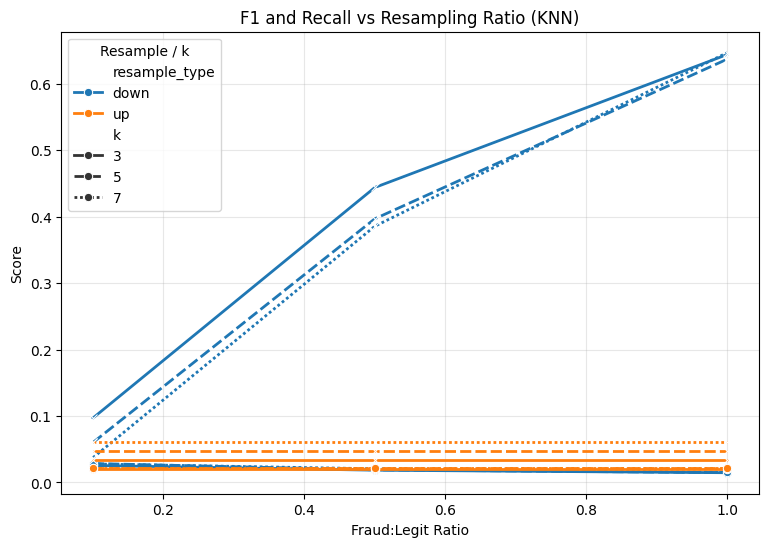

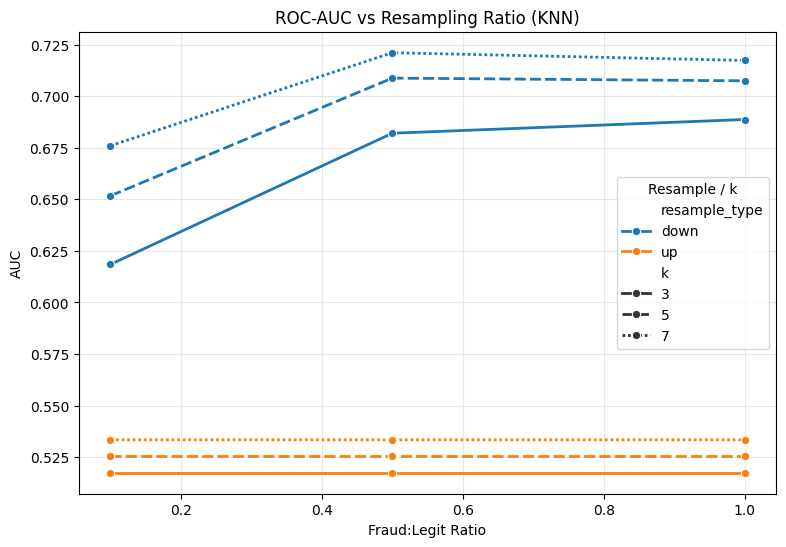


--- Mean Scores Summary ---
                       precision  recall     f1  roc_auc
k ratio resample_type                                   
3 0.1   down               0.015   0.097  0.026    0.618
        up                 0.015   0.034  0.020    0.517
  0.5   down               0.009   0.444  0.018    0.682
        up                 0.015   0.034  0.020    0.517
  1.0   down               0.007   0.644  0.015    0.689
        up                 0.015   0.034  0.020    0.517
5 0.1   down               0.019   0.060  0.028    0.652
        up                 0.014   0.048  0.022    0.526
  0.5   down               0.010   0.397  0.019    0.709
        up                 0.014   0.048  0.022    0.526
  1.0   down               0.007   0.637  0.015    0.707
        up                 0.014   0.048  0.022    0.526
7 0.1   down               0.022   0.037  0.028    0.676
        up                 0.013   0.062  0.022    0.533
  0.5   down               0.011   0.386  0.021    0.721
  

In [8]:
# ---
# 6. Plot Results
# ---
if not results_df.empty:
    print("\nGenerating plots...")
    
    # ---- Plot F1 & Recall vs Ratio ----
    plt.figure(figsize=(9, 6)) # Made it a bit bigger for the legend

    # Plot F1
    sns.lineplot(
        data=results_df, 
        x="ratio", 
        y="f1", 
        hue="resample_type",
        style="k",  # <-- This will show k=3, 5, 7
        marker="o", 
        linewidth=2
    )

    # Plot Recall on same chart
    sns.lineplot(
        data=results_df, 
        x="ratio", 
        y="recall", 
        hue="resample_type",
        style="k",
        marker="x", 
        linestyle="--", 
        linewidth=2,
        legend=False # Avoid duplicate legend entries
    )

    plt.title("F1 and Recall vs Resampling Ratio (KNN)")
    plt.xlabel("Fraud:Legit Ratio")
    plt.ylabel("Score")
    plt.grid(True, alpha=0.3)
    plt.legend(title="Resample / k") # Updated legend title
    plt.savefig("results/knn_f1_recall_plot.png")
    plt.show()

    # ---- Plot ROC-AUC vs Ratio ----
    plt.figure(figsize=(9, 6))
    sns.lineplot(
        data=results_df, 
        x="ratio", 
        y="roc_auc", 
        hue="resample_type",
        style="k",
        marker="o", 
        linewidth=2
    )
    plt.title("ROC-AUC vs Resampling Ratio (KNN)")
    plt.xlabel("Fraud:Legit Ratio")
    plt.ylabel("AUC")
    plt.grid(True, alpha=0.3)
    plt.legend(title="Resample / k")
    plt.savefig("results/knn_auc_plot.png")
    plt.show()
    
    # ---- Summary Table ----
    # Updated groupby to include 'k'
    summary = results_df.groupby(["k", "ratio", "resample_type"])[["precision", "recall", "f1", "roc_auc"]].mean().round(3)
    print("\n--- Mean Scores Summary ---")
    print(summary)

    print("\nPlots and summary complete.")
else:
    print("No results to plot.")